In [1]:
# 导入必要的库
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DoubleType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("库导入完成！")


库导入完成！


In [2]:
# 初始化 Spark Session 并加载清洗后的数据
spark = SparkSession.builder \
    .appName("TweetAnalysis_EDA_Sentiment") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

# 加载清洗后的数据（基于第二步的输出路径）
cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
print(f"尝试加载数据从: {cleaned_data_path}")

try:
    df_cleaned = spark.read.parquet(cleaned_data_path)
    df_cleaned.cache()
    record_count = df_cleaned.count()
    print(f"✅ 清洗后数据加载完成，共 {record_count:,} 条记录")
    print("\n数据结构:")
    df_cleaned.printSchema()
    
    # 显示前几行数据预览
    print("\n数据预览（前3行）:")
    df_cleaned.select("id", "`subreddit.name`", "cleaned_body", "sentiment").show(3, truncate=False)
    
except Exception as e:
    print(f"❌ 数据加载失败: {e}")
    print("请确保已经运行完第二步数据清洗notebook")
    # 创建一个空的DataFrame作为fallback
    df_cleaned = None


Spark Version: 3.5.0
尝试加载数据从: /home/jovyan/work/data/processed/cleaned_comments.parquet
✅ 清洗后数据加载完成，共 459,171 条记录

数据结构:
root
 |-- id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- body: string (nullable = true)
 |-- cleaned_body: string (nullable = true)
 |-- tokens_cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: double (nullable = true)
 |-- score: long (nullable = true)


数据预览（前3行）:
+-------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|id     |subre

In [3]:
# 基础数据概览和统计
print("=== 基础数据概览 ===")

# 验证数据是否成功加载
if df_cleaned is None:
    print("❌ 数据未加载，请先运行上一个cell并确保数据加载成功")
else:
    # 1. 数据基本信息
    print("1. 数据基本信息:")
    print(f"总记录数: {df_cleaned.count():,}")
    print(f"总列数: {len(df_cleaned.columns)}")

    # 2. 各列数据完整性检查
    print("\n2. 数据完整性:")
    for col_name in df_cleaned.columns:
        # 处理包含点号的列名
        if "." in col_name:
            null_count = df_cleaned.filter(F.col(f"`{col_name}`").isNull()).count()
        else:
            null_count = df_cleaned.filter(F.col(col_name).isNull()).count()
        total_count = df_cleaned.count()
        print(f"  {col_name}: {((total_count - null_count) / total_count * 100):.1f}% 完整")

    # 3. 情感分数统计
    print("\n3. 情感分数分布:")
    sentiment_stats = df_cleaned.select("sentiment").describe()
    sentiment_stats.show()

    # 4. 子版块分布
    print("4. 子版块分布 (Top 10):")
    subreddit_dist = df_cleaned.groupBy("`subreddit.name`").count().orderBy(F.desc("count")).limit(10)
    subreddit_dist.show(truncate=False)


=== 基础数据概览 ===
1. 数据基本信息:
总记录数: 459,171
总列数: 9

2. 数据完整性:
  id: 100.0% 完整
  subreddit.name: 100.0% 完整
  created_utc: 100.0% 完整
  timestamp: 100.0% 完整
  body: 100.0% 完整
  cleaned_body: 100.0% 完整
  tokens_cleaned: 100.0% 完整
  sentiment: 98.9% 完整
  score: 100.0% 完整

3. 情感分数分布:
+-------+--------------------+
|summary|           sentiment|
+-------+--------------------+
|  count|              454264|
|   mean|-0.00644086346265...|
| stddev|  0.6588389261269937|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+

4. 子版块分布 (Top 10):
+--------------+-----+
|subreddit.name|count|
+--------------+-----+
|politics      |36989|
|worldnews     |35283|
|askreddit     |25863|
|news          |9524 |
|collapse      |9490 |
|futurology    |8904 |
|science       |7063 |
|environment   |6819 |
|canada        |6722 |
|australia     |5993 |
+--------------+-----+



In [4]:
# 使用VADER进行重新情感分析（改进原有情感分数）
print("=== VADER情感分析 ===")

# 验证数据是否可用
if df_cleaned is None:
    print("❌ 数据未加载，请先运行前面的cells并确保数据加载成功")
else:
    # 创建VADER情感分析器
    analyzer = SentimentIntensityAnalyzer()

    def analyze_sentiment_vader(text):
        """使用VADER进行情感分析"""
        if text is None:
            return None
        scores = analyzer.polarity_scores(str(text))
        return scores['compound']  # 返回复合情感分数 (-1 到 1)

    # 创建UDF用于Spark
    sentiment_udf = F.udf(analyze_sentiment_vader, DoubleType())

    # 应用VADER情感分析到清洗后的文本
    print("正在应用VADER情感分析...")
    df_with_vader = df_cleaned.withColumn("vader_sentiment", sentiment_udf(F.col("cleaned_body")))

    # 缓存结果
    df_with_vader.cache()

    print("VADER情感分析完成！")

    # 比较原始情感分数和VADER分数
    print("\n原始情感分数 vs VADER分数对比:")
    comparison = df_with_vader.select("sentiment", "vader_sentiment").filter(
        F.col("sentiment").isNotNull() & F.col("vader_sentiment").isNotNull()
    ).limit(10)
    comparison.show()

    # VADER情感分数统计
    print("\nVADER情感分数统计:")
    vader_stats = df_with_vader.select("vader_sentiment").describe()
    vader_stats.show()


=== VADER情感分析 ===
正在应用VADER情感分析...
VADER情感分析完成！

原始情感分数 vs VADER分数对比:
+---------+---------------+
|sentiment|vader_sentiment|
+---------+---------------+
|   0.5106|         0.5106|
|      0.0|            0.0|
|   0.7269|         0.7269|
|   0.6021|         0.6021|
|  -0.9824|         -0.992|
|   0.8948|         0.8948|
|  -0.8556|        -0.6997|
|    -0.25|          -0.25|
|    0.398|         0.7949|
|  -0.9118|        -0.9118|
+---------+---------------+


VADER情感分数统计:
+-------+--------------------+
|summary|     vader_sentiment|
+-------+--------------------+
|  count|              459171|
|   mean|0.007410569482828808|
| stddev|  0.6618577281362763|
|    min|             -0.9999|
|    max|              0.9999|
+-------+--------------------+



=== 情感分布分析 ===
正在准备可视化数据...

情感分布:
  sentiment_category   count
0           Positive  211657
1            Neutral   38668
2           Negative  208846


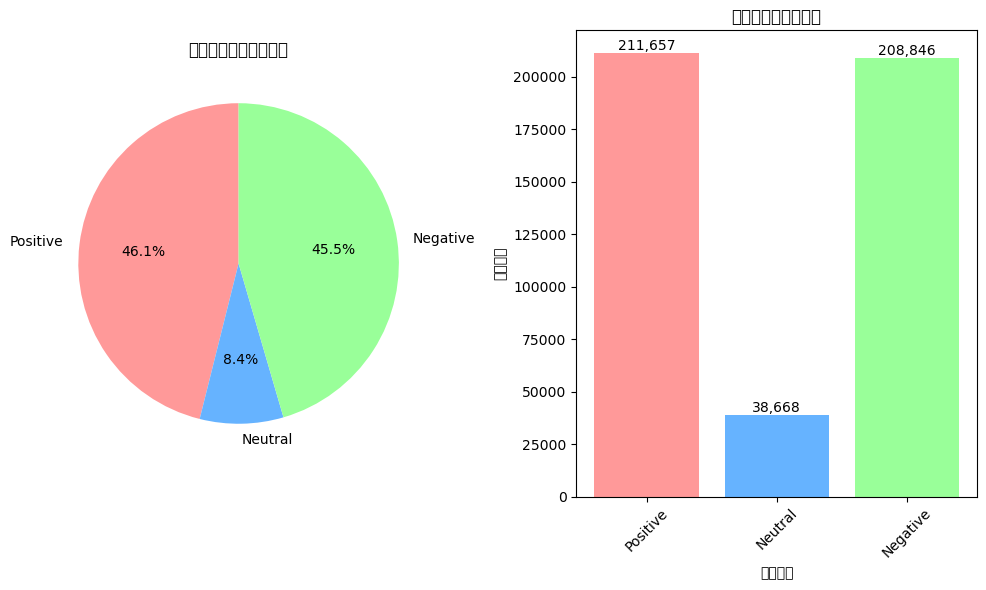

情感分布可视化完成！


In [5]:
# 情感分布分析和可视化
print("=== 情感分布分析 ===")

# 验证前面的VADER分析是否完成
try:
    df_with_vader
    print("正在准备可视化数据...")
    
    # 创建情感分类
    def categorize_sentiment(score):
        if score is None:
            return "Unknown"
        elif score > 0.05:
            return "Positive"
        elif score < -0.05:
            return "Negative"
        else:
            return "Neutral"

    categorize_udf = F.udf(categorize_sentiment, StringType())

    # 应用情感分类
    df_categorized = df_with_vader.withColumn("sentiment_category", categorize_udf(F.col("vader_sentiment")))

    # 转换为Pandas进行分析
    sentiment_dist = df_categorized.groupBy("sentiment_category").count().toPandas()
    print("\n情感分布:")
    print(sentiment_dist)

    # 绘制情感分布饼图
    plt.figure(figsize=(10, 6))

    # 饼图
    plt.subplot(1, 2, 1)
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    plt.pie(sentiment_dist['count'], labels=sentiment_dist['sentiment_category'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('气候变化评论情感分布')

    # 柱状图
    plt.subplot(1, 2, 2)
    bars = plt.bar(sentiment_dist['sentiment_category'], sentiment_dist['count'], color=colors)
    plt.title('各情感类别评论数量')
    plt.xlabel('情感类别')
    plt.ylabel('评论数量')
    plt.xticks(rotation=45)

    # 在柱状图上添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("情感分布可视化完成！")
    
except NameError:
    print("❌ VADER情感分析未完成，请先运行前面的cells")


=== 子版块情感分析 ===
主要子版块情感分析结果:
  subreddit.name  comment_count  avg_sentiment  positive_count  \
0       politics          36989      -0.001880           17038   
1      worldnews          35283      -0.042786           15327   
2      askreddit          25863      -0.064260            9483   
3           news           9524      -0.077059            3875   
4       collapse           9490      -0.113639            3813   
5     futurology           8904       0.018289            4188   
6        science           7063       0.064287            3535   
7    environment           6819       0.001119            3130   
8         canada           6722       0.048966            3293   
9      australia           5993      -0.011873            2720   

   negative_count  neutral_count  
0           17318           2633  
1           17300           2656  
2           11952           4428  
3            4820            829  
4            5053            624  
5            4061            655  

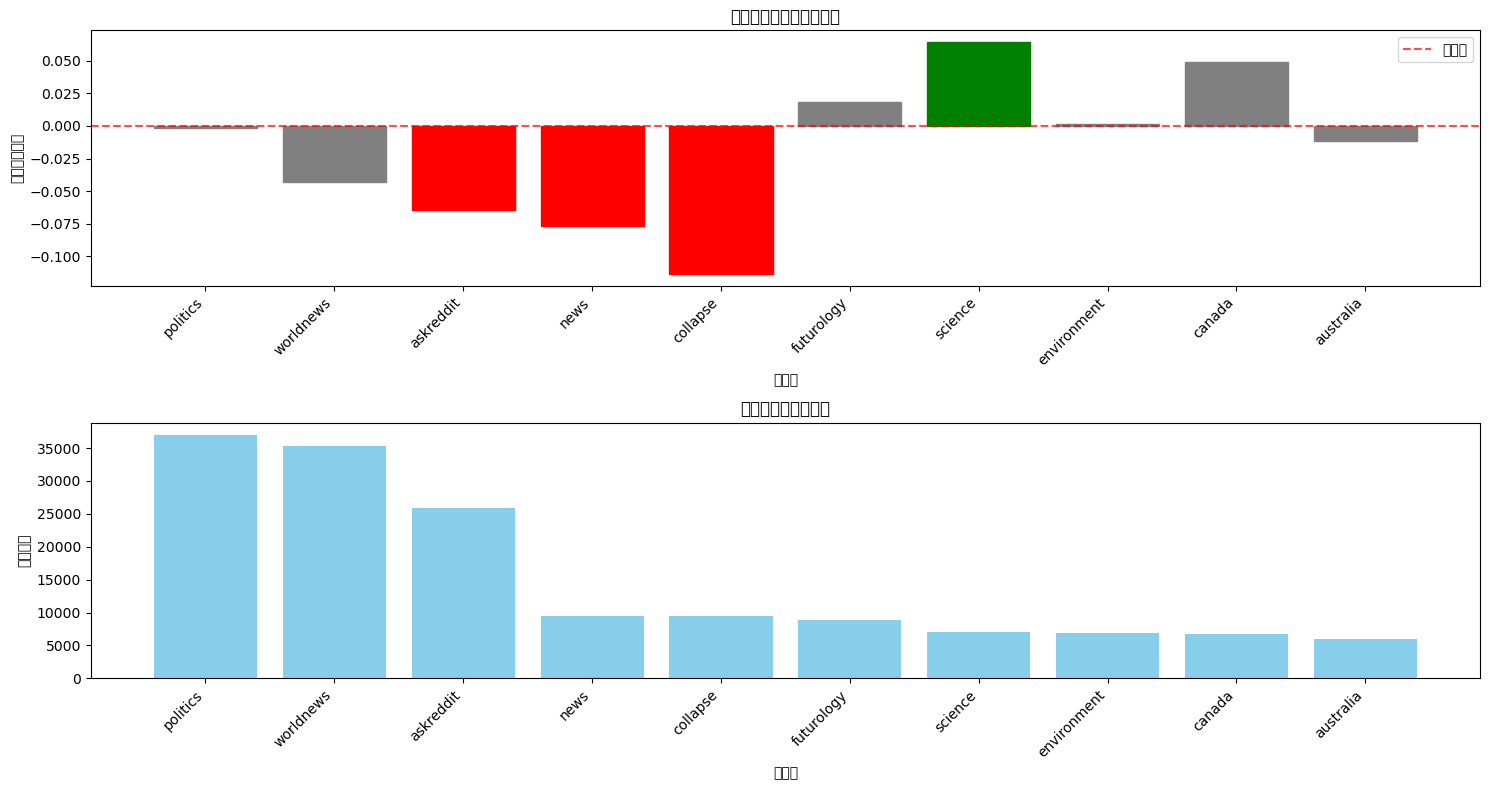

子版块情感分析可视化完成！


In [6]:
# 子版块情感分析
print("=== 子版块情感分析 ===")

# 验证情感分类数据是否可用
try:
    df_categorized
    
    # 计算各子版块的平均情感分数
    subreddit_sentiment = df_categorized.groupBy("`subreddit.name`").agg(
        F.count("*").alias("comment_count"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).filter(F.col("comment_count") >= 1000).orderBy(F.desc("comment_count"))

    # 转换为Pandas并显示
    subreddit_sentiment_pd = subreddit_sentiment.toPandas()
    print("主要子版块情感分析结果:")
    print(subreddit_sentiment_pd.head(10))

    # 绘制子版块情感对比图
    plt.figure(figsize=(15, 8))

    # 选择前10个最活跃的子版块
    top_subreddits = subreddit_sentiment_pd.head(10)

    # 子版块平均情感分数
    plt.subplot(2, 1, 1)
    bars = plt.bar(range(len(top_subreddits)), top_subreddits['avg_sentiment'])
    plt.title('主要子版块平均情感分数')
    plt.xlabel('子版块')
    plt.ylabel('平均情感分数')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='中性线')
    plt.legend()

    # 为柱状图添加颜色（正面绿色，负面红色，中性灰色）
    for i, bar in enumerate(bars):
        if top_subreddits.iloc[i]['avg_sentiment'] > 0.05:
            bar.set_color('green')
        elif top_subreddits.iloc[i]['avg_sentiment'] < -0.05:
            bar.set_color('red')
        else:
            bar.set_color('gray')

    # 子版块评论数量
    plt.subplot(2, 1, 2)
    plt.bar(range(len(top_subreddits)), top_subreddits['comment_count'], color='skyblue')
    plt.title('主要子版块评论数量')
    plt.xlabel('子版块')
    plt.ylabel('评论数量')
    plt.xticks(range(len(top_subreddits)), top_subreddits['subreddit.name'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("子版块情感分析可视化完成！")
    
except NameError:
    print("❌ 情感分类数据未准备好，请先运行前面的cells")


=== 时间序列情感分析 ===
年度情感趋势分析:
    year  total_comments  avg_sentiment  positive_count  negative_count  \
0   2010            1595       0.044215             791             692   
1   2011            2657       0.077628            1362            1097   
2   2012            4038       0.075008            2081            1689   
3   2013            6512       0.044751            3197            2889   
4   2014           11308       0.023823            5334            5080   
5   2015           16822       0.016500            7896            7626   
6   2016           31363       0.019203           14815           14141   
7   2017           37708       0.025033           17827           16817   
8   2018           38714      -0.001614           17768           17808   
9   2019           98076      -0.014628           43465           45770   
10  2020           70049       0.008886           32390           31971   
11  2021           81871       0.014139           38118           36697  

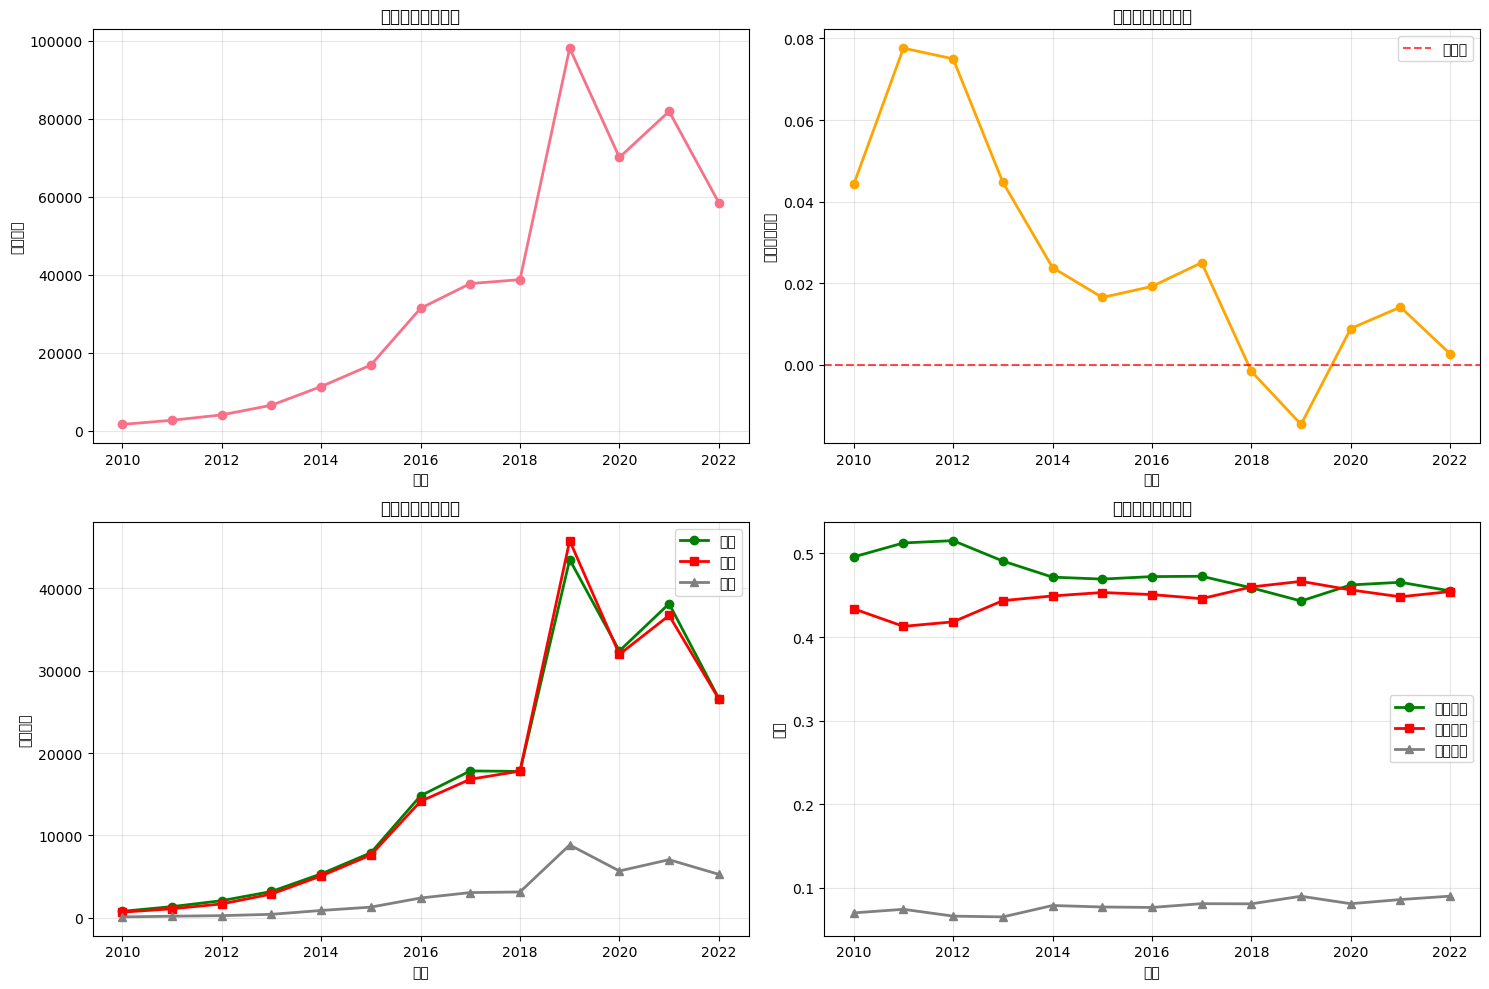

时间序列情感分析完成！


In [7]:
# 时间序列情感分析
print("=== 时间序列情感分析 ===")

# 验证情感分类数据是否可用
try:
    df_categorized
    
    # 从timestamp中提取年份
    df_with_year = df_categorized.withColumn("year", F.year(F.col("timestamp")))
    
    # 按年份分析情感趋势
    yearly_sentiment = df_with_year.groupBy("year").agg(
        F.count("*").alias("total_comments"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).orderBy("year")
    
    # 转换为Pandas进行可视化
    yearly_sentiment_pd = yearly_sentiment.toPandas()
    print("年度情感趋势分析:")
    print(yearly_sentiment_pd)
    
    # 绘制时间序列图
    plt.figure(figsize=(15, 10))
    
    # 年度评论数量趋势
    plt.subplot(2, 2, 1)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['total_comments'], marker='o', linewidth=2)
    plt.title('年度评论数量趋势')
    plt.xlabel('年份')
    plt.ylabel('评论数量')
    plt.grid(True, alpha=0.3)
    
    # 年度平均情感趋势
    plt.subplot(2, 2, 2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['avg_sentiment'], 
             marker='o', linewidth=2, color='orange')
    plt.title('年度平均情感趋势')
    plt.xlabel('年份')
    plt.ylabel('平均情感分数')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='中性线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 情感类别年度分布
    plt.subplot(2, 2, 3)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_count'], 
             marker='o', label='正面', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_count'], 
             marker='s', label='负面', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_count'], 
             marker='^', label='中性', color='gray', linewidth=2)
    plt.title('年度情感类别分布')
    plt.xlabel('年份')
    plt.ylabel('评论数量')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 情感比例年度变化
    plt.subplot(2, 2, 4)
    yearly_sentiment_pd['positive_ratio'] = yearly_sentiment_pd['positive_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['negative_ratio'] = yearly_sentiment_pd['negative_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['neutral_ratio'] = yearly_sentiment_pd['neutral_count'] / yearly_sentiment_pd['total_comments']
    
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_ratio'], 
             marker='o', label='正面比例', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_ratio'], 
             marker='s', label='负面比例', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_ratio'], 
             marker='^', label='中性比例', color='gray', linewidth=2)
    plt.title('年度情感比例变化')
    plt.xlabel('年份')
    plt.ylabel('比例')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("时间序列情感分析完成！")
    
except NameError:
    print("❌ 情感分类数据未准备好，请先运行前面的cells")


=== 词频分析和词云生成 ===
正在分析词频...
Top 20 高频词:
      token   count
0   climate  606389
1    change  409329
2    people  229781
3      like  173685
4        re  125493
5     think  122634
6       one  115179
7      even  112339
8         .  101838
9         m   98188
10      get   94738
11  change.   93347
12     also   87322
13    going   81535
14       us   80472
15     much   80098
16     make   77048
17    world   73923
18     need   68267
19     know   68190

分析不同情感类别的词频...
正在生成词云...


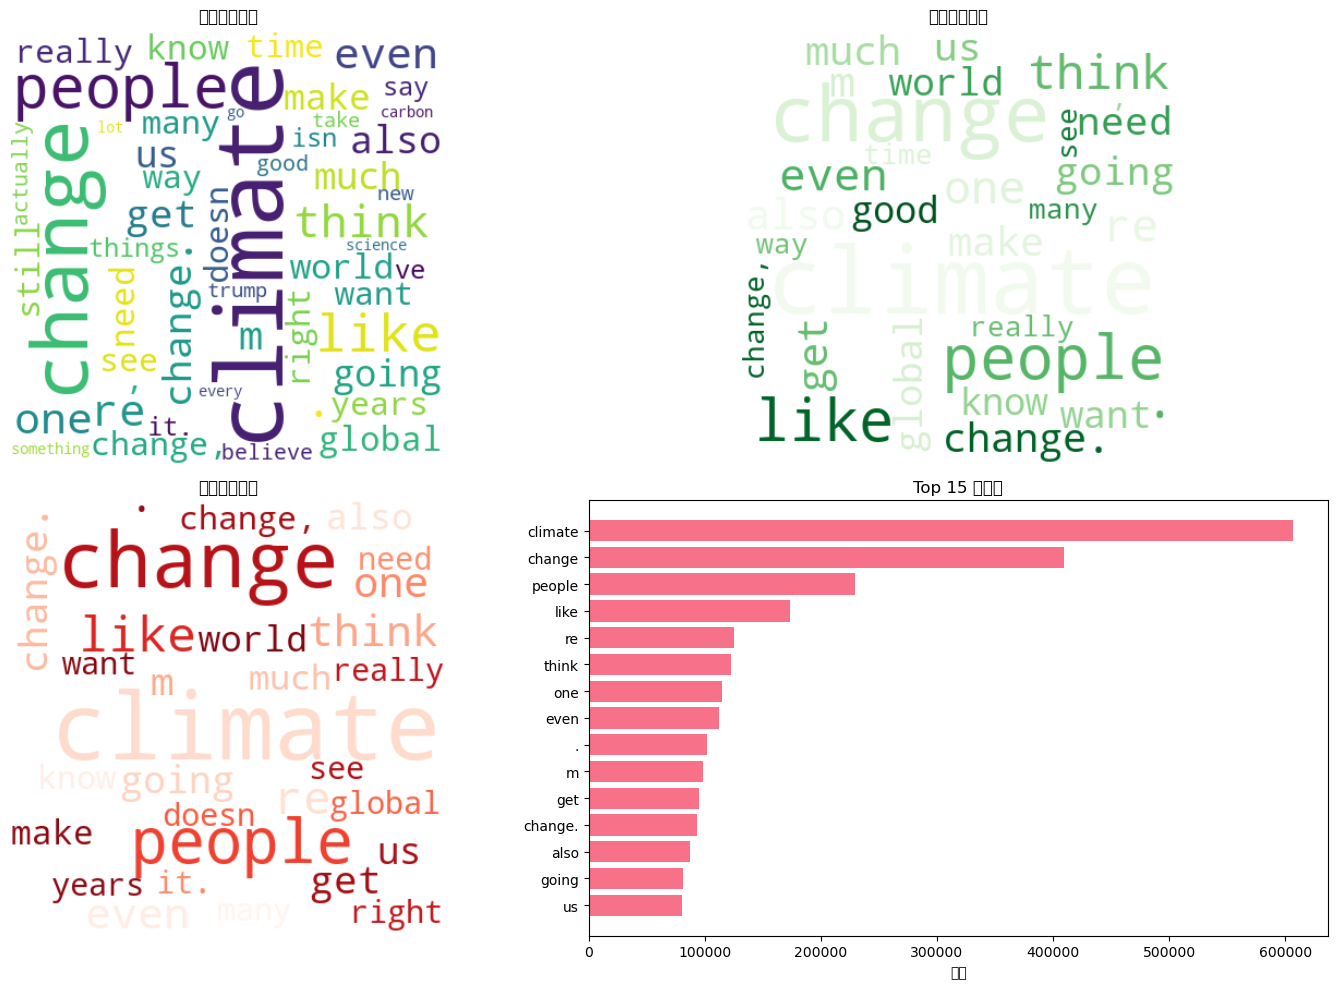

词频分析和词云生成完成！


In [8]:
# 词频分析和词云生成
print("=== 词频分析和词云生成 ===")

# 验证分类数据是否可用
try:
    df_categorized
    
    # 从tokens_cleaned中提取所有词汇
    print("正在分析词频...")

    # 将所有token展开并计算频率
    all_tokens = df_categorized.select(F.explode(F.col("tokens_cleaned")).alias("token"))
    word_freq = all_tokens.groupBy("token").count().orderBy(F.desc("count"))

    # 获取前50个高频词
    top_words = word_freq.limit(50).toPandas()
    print("Top 20 高频词:")
    print(top_words.head(20))

    # 分别分析正面和负面评论的词频
    print("\n分析不同情感类别的词频...")

    # 正面评论的词频
    positive_tokens = df_categorized.filter(F.col("sentiment_category") == "Positive").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    positive_word_freq = positive_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # 负面评论的词频
    negative_tokens = df_categorized.filter(F.col("sentiment_category") == "Negative").select(
        F.explode(F.col("tokens_cleaned")).alias("token")
    )
    negative_word_freq = negative_tokens.groupBy("token").count().orderBy(F.desc("count")).limit(30).toPandas()

    # 生成词云
    print("正在生成词云...")

    # 准备词云数据
    word_freq_dict = dict(zip(top_words['token'], top_words['count']))

    # 生成整体词云
    plt.figure(figsize=(15, 10))

    # 整体词云
    plt.subplot(2, 2, 1)
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                         max_words=100, colormap='viridis').generate_from_frequencies(word_freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('整体高频词云')
    plt.axis('off')

    # 正面评论词云
    plt.subplot(2, 2, 2)
    positive_dict = dict(zip(positive_word_freq['token'], positive_word_freq['count']))
    positive_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Greens').generate_from_frequencies(positive_dict)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('正面评论词云')
    plt.axis('off')

    # 负面评论词云
    plt.subplot(2, 2, 3)
    negative_dict = dict(zip(negative_word_freq['token'], negative_word_freq['count']))
    negative_wordcloud = WordCloud(width=400, height=400, background_color='white',
                                  max_words=50, colormap='Reds').generate_from_frequencies(negative_dict)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('负面评论词云')
    plt.axis('off')

    # 词频对比图
    plt.subplot(2, 2, 4)
    top_15_words = top_words.head(15)
    plt.barh(range(len(top_15_words)), top_15_words['count'])
    plt.yticks(range(len(top_15_words)), top_15_words['token'])
    plt.xlabel('词频')
    plt.title('Top 15 高频词')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    print("词频分析和词云生成完成！")
    
except NameError:
    print("❌ 分类数据未准备好，请先运行前面的cells")


=== 时间序列情感分析 ===
年度情感趋势分析:
    year  total_comments  avg_sentiment  positive_count  negative_count  \
0   2010            1595       0.044215             791             692   
1   2011            2657       0.077628            1362            1097   
2   2012            4038       0.075008            2081            1689   
3   2013            6512       0.044751            3197            2889   
4   2014           11308       0.023823            5334            5080   
5   2015           16822       0.016500            7896            7626   
6   2016           31363       0.019203           14815           14141   
7   2017           37708       0.025033           17827           16817   
8   2018           38714      -0.001614           17768           17808   
9   2019           98076      -0.014628           43465           45770   
10  2020           70049       0.008886           32390           31971   
11  2021           81871       0.014139           38118           36697  

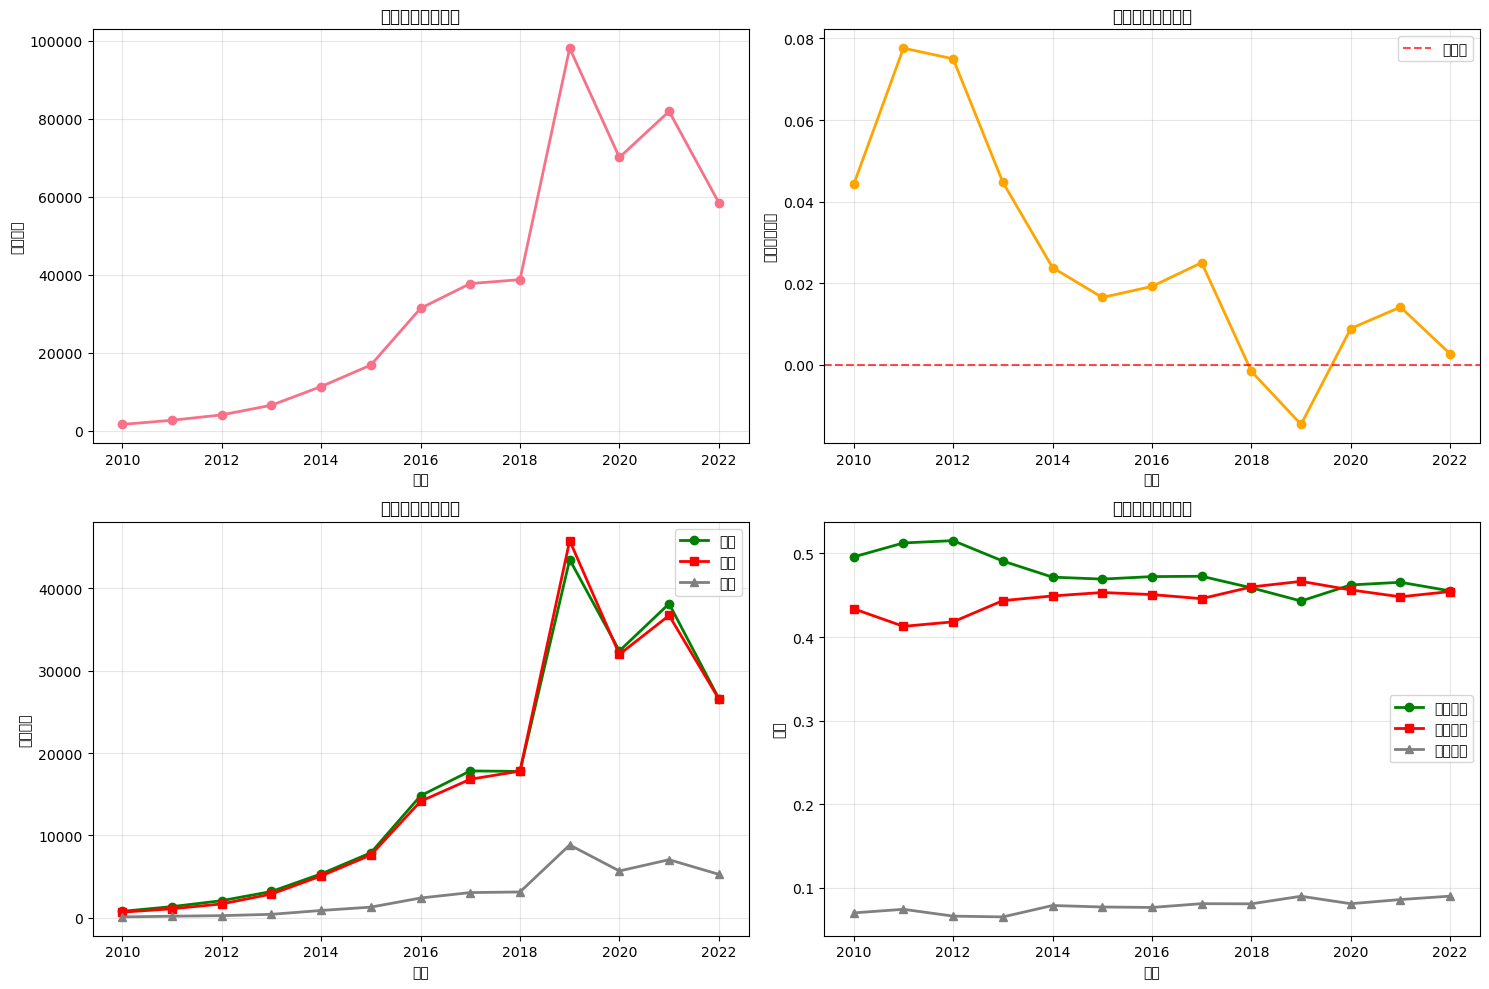

时间序列情感分析完成！


In [9]:



# 时间序列情感分析
print("=== 时间序列情感分析 ===")

# 验证情感分类数据是否可用
try:
    df_categorized
    
    # 从timestamp中提取年份
    df_with_year = df_categorized.withColumn("year", F.year(F.col("timestamp")))
    
    # 按年份分析情感趋势
    yearly_sentiment = df_with_year.groupBy("year").agg(
        F.count("*").alias("total_comments"),
        F.avg("vader_sentiment").alias("avg_sentiment"),
        F.sum(F.when(F.col("sentiment_category") == "Positive", 1).otherwise(0)).alias("positive_count"),
        F.sum(F.when(F.col("sentiment_category") == "Negative", 1).otherwise(0)).alias("negative_count"),
        F.sum(F.when(F.col("sentiment_category") == "Neutral", 1).otherwise(0)).alias("neutral_count")
    ).orderBy("year")
    
    # 转换为Pandas进行可视化
    yearly_sentiment_pd = yearly_sentiment.toPandas()
    print("年度情感趋势分析:")
    print(yearly_sentiment_pd)
    
    # 绘制时间序列图
    plt.figure(figsize=(15, 10))
    
    # 年度评论数量趋势
    plt.subplot(2, 2, 1)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['total_comments'], marker='o', linewidth=2)
    plt.title('年度评论数量趋势')
    plt.xlabel('年份')
    plt.ylabel('评论数量')
    plt.grid(True, alpha=0.3)
    
    # 年度平均情感趋势
    plt.subplot(2, 2, 2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['avg_sentiment'], 
             marker='o', linewidth=2, color='orange')
    plt.title('年度平均情感趋势')
    plt.xlabel('年份')
    plt.ylabel('平均情感分数')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='中性线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 情感类别年度分布
    plt.subplot(2, 2, 3)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_count'], 
             marker='o', label='正面', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_count'], 
             marker='s', label='负面', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_count'], 
             marker='^', label='中性', color='gray', linewidth=2)
    plt.title('年度情感类别分布')
    plt.xlabel('年份')
    plt.ylabel('评论数量')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 情感比例年度变化
    plt.subplot(2, 2, 4)
    yearly_sentiment_pd['positive_ratio'] = yearly_sentiment_pd['positive_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['negative_ratio'] = yearly_sentiment_pd['negative_count'] / yearly_sentiment_pd['total_comments']
    yearly_sentiment_pd['neutral_ratio'] = yearly_sentiment_pd['neutral_count'] / yearly_sentiment_pd['total_comments']
    
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['positive_ratio'], 
             marker='o', label='正面比例', color='green', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['negative_ratio'], 
             marker='s', label='负面比例', color='red', linewidth=2)
    plt.plot(yearly_sentiment_pd['year'], yearly_sentiment_pd['neutral_ratio'], 
             marker='^', label='中性比例', color='gray', linewidth=2)
    plt.title('年度情感比例变化')
    plt.xlabel('年份')
    plt.ylabel('比例')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("时间序列情感分析完成！")
    
except NameError:
    print("❌ 情感分类数据未准备好，请先运行前面的cells")

In [10]:
# 分析总结和保存结果
print("=== 探索性数据分析总结 ===")

# 验证所有必要的数据是否可用
try:
    df_categorized
    subreddit_sentiment_pd
    yearly_sentiment_pd

    # 生成分析报告
    total_comments = df_categorized.count()
    sentiment_dist_final = df_categorized.groupBy("sentiment_category").count().toPandas()

    print("📊 **数据概览**:")
    print(f"   总评论数: {total_comments:,}")
    print(f"   分析时间跨度: 2010-2022年")
    print(f"   主要子版块: politics, worldnews, askreddit")

    print("\n🎭 **情感分布**:")
    for _, row in sentiment_dist_final.iterrows():
        percentage = (row['count'] / total_comments) * 100
        print(f"   {row['sentiment_category']}: {row['count']:,} ({percentage:.1f}%)")

    print("\n📈 **关键发现**:")
    yearly_summary = yearly_sentiment_pd
    if len(yearly_summary) > 0:
        print(f"   最负面年份: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmin(), 'year']}")
        print(f"   最正面年份: {yearly_summary.loc[yearly_summary['avg_sentiment'].idxmax(), 'year']}")
        print(f"   评论数最多年份: {yearly_summary.loc[yearly_summary['total_comments'].idxmax(), 'year']}")

    print("\n🏷️ **子版块特点**:")
    if len(subreddit_sentiment_pd) > 0:
        most_positive = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmax()]
        most_negative = subreddit_sentiment_pd.loc[subreddit_sentiment_pd['avg_sentiment'].idxmin()]
        print(f"   最正面子版块: {most_positive['subreddit.name']} (得分: {most_positive['avg_sentiment']:.3f})")
        print(f"   最负面子版块: {most_negative['subreddit.name']} (得分: {most_negative['avg_sentiment']:.3f})")

    print("\n💾 **保存增强后的数据**:")
    output_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"
    print(f"正在保存到: {output_path}")

    try:
        df_categorized.select(
            "id", "`subreddit.name`", "created_utc", "timestamp",
            "body", "cleaned_body", "tokens_cleaned", "sentiment",
            "vader_sentiment", "sentiment_category", "score"
        ).write.mode("overwrite").parquet(output_path)
        print("✅ 情感分析结果保存成功！")
    except Exception as e:
        print(f"❌ 保存失败: {e}")

    print("\n🎯 **下一步建议**:")
    print("   1. 基于情感分析结果进行主题建模 (LDA)")
    print("   2. 训练机器学习分类模型")
    print("   3. 深入分析特定事件对情感的影响")
    print("   4. 构建情感预测模型")

    print("\n✅ 探索性数据分析和情感分析完成！")

except NameError:
    print("❌ 分析数据未准备好，请先运行前面的所有cells")


=== 探索性数据分析总结 ===
📊 **数据概览**:
   总评论数: 459,171
   分析时间跨度: 2010-2022年
   主要子版块: politics, worldnews, askreddit

🎭 **情感分布**:
   Positive: 211,657 (46.1%)
   Neutral: 38,668 (8.4%)
   Negative: 208,846 (45.5%)

📈 **关键发现**:
   最负面年份: 2019
   最正面年份: 2011
   评论数最多年份: 2019

🏷️ **子版块特点**:
   最正面子版块: bottown2 (得分: 0.229)
   最负面子版块: publicfreakout (得分: -0.211)

💾 **保存增强后的数据**:
正在保存到: /home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet
✅ 情感分析结果保存成功！

🎯 **下一步建议**:
   1. 基于情感分析结果进行主题建模 (LDA)
   2. 训练机器学习分类模型
   3. 深入分析特定事件对情感的影响
   4. 构建情感预测模型

✅ 探索性数据分析和情感分析完成！


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 35466)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =